In [691]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, roc_auc_score
from tqdm import tqdm

In [227]:
maestro_consultora = pd.read_csv('maestro_consultora.csv').iloc[:, 1:]
maestro_consultora.head()

,campanaingreso,campanaultimopedido,IdConsultora,estadocivil,flagsupervisor,campanaprimerpedido,flagconsultoradigital,flagcorreovalidad,edad,flagcelularvalidado
0,200907,201915,431,Casado(a),0,200907.0,0,0.0,58,1
1,199708,201914,2010,Casado(a),0,199708.0,0,NaN,58,1
2,199709,201914,3513,Casado(a),0,199709.0,0,NaN,60,1
3,201813,201911,4895,Casado(a),0,201813.0,0,NaN,50,1
4,199711,201914,6233,Casado(a),0,199711.0,0,NaN,65,1


In [466]:
edad, edad_labels = pd.qcut(maestro_consultora['edad'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], retbins=True)
maestro_consultora['edad_cuartil'] = edad

In [712]:
consultora_filter = pd.get_dummies(maestro_consultora[
    ['IdConsultora', 'campanaingreso', 'campanaultimopedido', 'campanaprimerpedido', 'edad_cuartil', 'flagsupervisor']
])
consultora_filter.head()

,IdConsultora,campanaingreso,campanaultimopedido,campanaprimerpedido,flagsupervisor,edad_cuartil_Q1,edad_cuartil_Q2,edad_cuartil_Q3,edad_cuartil_Q4
0,431,200907,201915,200907.0,0,0,0,0,1
1,2010,199708,201914,199708.0,0,0,0,0,1
2,3513,199709,201914,199709.0,0,0,0,0,1
3,4895,201813,201911,201813.0,0,0,0,0,1
4,6233,199711,201914,199711.0,0,0,0,0,1


In [713]:
maestro_producto = pd.read_csv('maestro_producto.csv').iloc[:, 1:]
maestro_producto.head()

,idproducto,codigounidadnegocio,unidadnegocio,codigomarca,marca,codigocategoria,categoria,codigotipo,tipo
0,200056246,10,COSMETICOS,2,ESIKA,01,FRAGANCIAS,001,FRAGANCIAS/DAMAS/COLONIA Y O EAU DE TOILETE
1,200089626,10,COSMETICOS,2,ESIKA,04,CUIDADO PERSONAL,035,CUIDADO PERSONAL/TALCOS/ESPECIFICOS
2,200095496,10,COSMETICOS,2,ESIKA,01,FRAGANCIAS,001,FRAGANCIAS/DAMAS/COLONIA Y O EAU DE TOILETE
3,210089216,50,APOYO,2,ESIKA,72,PROMOCION USUARIOS,553,PROMOCION USUARIOS/HOGAR/BLOQUE MAQUILLAJE
4,200090369,10,COSMETICOS,3,CYZONE,02,MAQUILLAJE,027,MAQUILLAJE/PARA LABIOS/LAPIZ LABIAL


In [714]:
venta_campaña = pd.read_csv('dtt_fvta_cl.csv')
venta_campaña.head()

/Users/isaiashl/Desktop/env_adela/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,campana,idconsultora,codigotipooferta,descuento,ahorro,canalingresoproducto,idproducto,codigopalancapersonalizacion,palancapersonalizacion,preciocatalogo,...,realanulmnneto,realdevmnneto,realuuanuladas,realuudevueltas,realuufaltantes,realuuvendidas,realvtamnfaltneto,realvtamnneto,realvtamncatalogo,realvtamnfaltcatalogo
0,201807,544706,1,0.0,7990.0,NaN,200091158,12.0,NaN,5495.0,...,0.0,0.0,0,0,0,2,0.0,9236.0,10990.0,0.0
1,201807,638877,1,0.0,3800.0,WEB,200091762,1111.0,NaN,7690.0,...,0.0,0.0,0,0,0,1,0.0,6462.0,7690.0,0.0
2,201807,186016,1,0.0,3800.0,APP,200091762,42.0,NaN,7690.0,...,0.0,0.0,0,0,0,1,0.0,6462.0,7690.0,0.0
3,201807,579940,1,0.0,32748.0,WEB,200091762,12.0,NaN,6032.0,...,0.0,0.0,0,0,0,6,0.0,30414.0,36192.0,0.0
4,201807,342158,1,0.0,17272.0,WEB,200091762,12.0,NaN,7172.0,...,0.0,0.0,0,0,0,4,0.0,24108.0,28688.0,0.0


In [715]:
campaña_consultora['IdConsultora'].unique().shape, consultora_filter['IdConsultora'].unique().shape

((123740,), (123740,))

In [744]:
campaña_consultora = pd.read_csv('campana_consultora.csv').iloc[:,1:]
campaña_consultora = campaña_consultora.sort_values(by=['IdConsultora', 'campana'])
campaña_consultora.head()

,campana,IdConsultora,Flagpasopedido,flagactiva,flagpasopedidocuidadopersonal,flagpasopedidomaquillaje,flagpasopedidotratamientocorporal,flagpasopedidotratamientofacial,flagpedidoanulado,flagpasopedidofragancias,...,codigocanalorigen,evaluacion_nuevas,segmentacion,flagpasopedidoweb,cantidadlogueos,flagdispositivo,flagdigital,flagofertadigital,flagsuscripcion,geografia
232,201807,125,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Est,Nivel2,0.0,NaN,0,NaN,0.0,0,13 STGO. / VI?A DEL MAR / VA
172361,201808,125,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Est,Nivel2,0.0,NaN,0,NaN,0.0,0,13 STGO. / VI?A DEL MAR / VA
320095,201809,125,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Est,Nivel2,0.0,NaN,0,NaN,0.0,0,13 STGO. / VI?A DEL MAR / VA
314240,201810,125,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Est,Nivel2,0.0,NaN,0,NaN,0.0,0,13 STGO. / VI?A DEL MAR / VA
526321,201811,125,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Est,Nivel2,0.0,NaN,0,NaN,0.0,0,13 STGO. / VI?A DEL MAR / VA


In [745]:
campaña_consultora = campaña_consultora.merge(consultora_filter[['IdConsultora', 'campanaultimopedido', 
                                                                 'flagsupervisor',
                                                                 'edad_cuartil_Q1', 'edad_cuartil_Q2', 
                                                                 'edad_cuartil_Q3', 'edad_cuartil_Q4']], 
                                              on='IdConsultora', how='left')
campaña_consultora.dropna(subset=['campanaultimopedido'], inplace=True)

In [746]:
campaña_consultora.tail()

,campana,IdConsultora,Flagpasopedido,flagactiva,flagpasopedidocuidadopersonal,flagpasopedidomaquillaje,flagpasopedidotratamientocorporal,flagpasopedidotratamientofacial,flagpedidoanulado,flagpasopedidofragancias,...,flagdigital,flagofertadigital,flagsuscripcion,geografia,campanaultimopedido,flagsupervisor,edad_cuartil_Q1,edad_cuartil_Q2,edad_cuartil_Q3,edad_cuartil_Q4
1501983,201906,815405,1,1,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0,15 SUR GRANDE,201908.0,0.0,0.0,0.0,1.0,0.0
1501984,201906,815407,1,1,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1,15 SUR GRANDE,201906.0,0.0,1.0,0.0,0.0,0.0
1501985,201906,815415,1,1,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0,15 SUR GRANDE,201910.0,0.0,0.0,0.0,0.0,1.0
1501986,201906,815416,1,1,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0,14 SANTIAGO / SUR CHICO,201914.0,0.0,1.0,0.0,0.0,0.0
1501987,201906,815452,1,1,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0,15 SUR GRANDE,201914.0,0.0,0.0,1.0,0.0,0.0


In [747]:
campaña_consultora['diff_ultimopedido'] = campaña_consultora['campanaultimopedido'] - campaña_consultora['campana']

In [748]:
campaña_agg1 = pd.DataFrame(
    venta_campaña.groupby(
        ['idconsultora', 'campana']
    )['ahorro', 'realvtamncatalogo', 'realvtamnneto', 'realanulmnneto', 'realdevmnneto', 'realuuanuladas', 
      'realuudevueltas', 'realuufaltantes', 'realuuvendidas', 'realvtamnfaltneto'].sum()
).reset_index()

In [749]:
campaña_agg1.rename(columns={'idconsultora': 'IdConsultora'}, inplace=True)
campaña_agg1.head()

,IdConsultora,campana,ahorro,realvtamncatalogo,realvtamnneto,realanulmnneto,realdevmnneto,realuuanuladas,realuudevueltas,realuufaltantes,realuuvendidas,realvtamnfaltneto
0,202,201807,16379.0,35710.0,25022.0,0.0,0.0,0,0,0,13,0.0
1,202,201810,19302.0,57680.0,39439.0,0.0,0.0,0,0,0,17,0.0
2,202,201812,21338.0,52930.0,38142.0,0.0,0.0,0,0,0,7,0.0
3,202,201813,8522.0,45810.0,29975.0,0.0,0.0,0,0,0,10,0.0
4,202,201814,14378.0,51910.0,37335.0,0.0,0.0,0,0,0,12,0.0


In [750]:
campaña_agg1.columns = ['IdConsultora', 'campana', 'ahorro_sum', 'realvtamncatalogo_sum',
       'realvtamnneto_sum', 'realanulmnneto_sum', 'realdevmnneto_sum', 'realuuanuladas_sum',
       'realuudevueltas_sum', 'realuufaltantes_sum', 'realuuvendidas_sum',
       'realvtamnfaltneto_sum']
campaña_agg1.columns

Index(['IdConsultora', 'campana', 'ahorro_sum', 'realvtamncatalogo_sum',
       'realvtamnneto_sum', 'realanulmnneto_sum', 'realdevmnneto_sum',
       'realuuanuladas_sum', 'realuudevueltas_sum', 'realuufaltantes_sum',
       'realuuvendidas_sum', 'realvtamnfaltneto_sum'],
      dtype='object')

In [751]:
campaña_agg2 = pd.DataFrame(
    venta_campaña.groupby(
        ['idconsultora', 'campana']
    )['ahorro', 'realvtamncatalogo', 'realvtamnneto', 'realanulmnneto', 'realdevmnneto', 'realuuanuladas', 
      'realuudevueltas', 'realuufaltantes', 'realuuvendidas', 'realvtamnfaltneto'].mean()
).reset_index()

In [752]:
campaña_agg2.rename(columns={'idconsultora': 'IdConsultora'}, inplace=True)
campaña_agg2.head()

,IdConsultora,campana,ahorro,realvtamncatalogo,realvtamnneto,realanulmnneto,realdevmnneto,realuuanuladas,realuudevueltas,realuufaltantes,realuuvendidas,realvtamnfaltneto
0,202,201807,1364.916667,2975.833333,2085.166667,0.0,0.0,0.0,0.0,0.0,1.083333,0.0
1,202,201810,1206.375000,3605.000000,2464.937500,0.0,0.0,0.0,0.0,0.0,1.062500,0.0
2,202,201812,3048.285714,7561.428571,5448.857143,0.0,0.0,0.0,0.0,0.0,1.000000,0.0
3,202,201813,946.888889,5090.000000,3330.555556,0.0,0.0,0.0,0.0,0.0,1.111111,0.0
4,202,201814,1597.555556,5767.777778,4148.333333,0.0,0.0,0.0,0.0,0.0,1.333333,0.0


In [753]:
campaña_agg2.columns = ['IdConsultora', 'campana', 'ahorro_mean', 'realvtamncatalogo_mean',
       'realvtamnneto_mean', 'realanulmnneto_mean', 'realdevmnneto_mean', 'realuuanuladas_mean',
       'realuudevueltas_mean', 'realuufaltantes_mean', 'realuuvendidas_mean',
       'realvtamnfaltneto_mean']
campaña_agg2.columns

Index(['IdConsultora', 'campana', 'ahorro_mean', 'realvtamncatalogo_mean',
       'realvtamnneto_mean', 'realanulmnneto_mean', 'realdevmnneto_mean',
       'realuuanuladas_mean', 'realuudevueltas_mean', 'realuufaltantes_mean',
       'realuuvendidas_mean', 'realvtamnfaltneto_mean'],
      dtype='object')

In [754]:
campaña_agg = campaña_agg1.merge(campaña_agg2, on=['IdConsultora', 'campana'])
campaña_agg.head()

,IdConsultora,campana,ahorro_sum,realvtamncatalogo_sum,realvtamnneto_sum,realanulmnneto_sum,realdevmnneto_sum,realuuanuladas_sum,realuudevueltas_sum,realuufaltantes_sum,...,ahorro_mean,realvtamncatalogo_mean,realvtamnneto_mean,realanulmnneto_mean,realdevmnneto_mean,realuuanuladas_mean,realuudevueltas_mean,realuufaltantes_mean,realuuvendidas_mean,realvtamnfaltneto_mean
0,202,201807,16379.0,35710.0,25022.0,0.0,0.0,0,0,0,...,1364.916667,2975.833333,2085.166667,0.0,0.0,0.0,0.0,0.0,1.083333,0.0
1,202,201810,19302.0,57680.0,39439.0,0.0,0.0,0,0,0,...,1206.375000,3605.000000,2464.937500,0.0,0.0,0.0,0.0,0.0,1.062500,0.0
2,202,201812,21338.0,52930.0,38142.0,0.0,0.0,0,0,0,...,3048.285714,7561.428571,5448.857143,0.0,0.0,0.0,0.0,0.0,1.000000,0.0
3,202,201813,8522.0,45810.0,29975.0,0.0,0.0,0,0,0,...,946.888889,5090.000000,3330.555556,0.0,0.0,0.0,0.0,0.0,1.111111,0.0
4,202,201814,14378.0,51910.0,37335.0,0.0,0.0,0,0,0,...,1597.555556,5767.777778,4148.333333,0.0,0.0,0.0,0.0,0.0,1.333333,0.0


In [755]:
set_a = set(campaña_agg['IdConsultora'].unique().tolist()) 
set_b = set(campaña_consultora['IdConsultora'].unique().tolist())
inter_ = set_a & set_b

In [756]:
campaña_merge = campaña_consultora.merge(campaña_agg, on=['IdConsultora', 'campana'], how='left')
campaña_merge = campaña_merge.sort_values(by=['IdConsultora', 'campana'])
campaña_merge = campaña_merge.drop(['codigocanalorigen'], axis=1)
campaña_merge.fillna(0, inplace=True)
campaña_merge.head()

,campana,IdConsultora,Flagpasopedido,flagactiva,flagpasopedidocuidadopersonal,flagpasopedidomaquillaje,flagpasopedidotratamientocorporal,flagpasopedidotratamientofacial,flagpedidoanulado,flagpasopedidofragancias,...,ahorro_mean,realvtamncatalogo_mean,realvtamnneto_mean,realanulmnneto_mean,realdevmnneto_mean,realuuanuladas_mean,realuudevueltas_mean,realuufaltantes_mean,realuuvendidas_mean,realvtamnfaltneto_mean
0,201807,125,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,201808,125,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,201809,125,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,201810,125,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,201811,125,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [757]:
campaña_merge['Flag_shift'] = campaña_merge.groupby('IdConsultora')['Flagpasopedido'].shift(-1)
campaña_merge = campaña_merge.select_dtypes(exclude=['object'])

In [758]:
df_val = campaña_merge[campaña_merge['Flag_shift'].isnull()].set_index(['IdConsultora', 'campana'])
df_model = campaña_merge[campaña_merge['Flag_shift'].notna()].set_index(['IdConsultora', 'campana'])

In [759]:
X = df_model.drop(['Flag_shift', 'campanaultimopedido', 'flagdigital', 'Flagpasopedido', 'flagpedidoanulado'], axis=1)
y = df_model['Flag_shift']

In [760]:
X.columns

Index(['flagactiva', 'flagpasopedidocuidadopersonal',
       'flagpasopedidomaquillaje', 'flagpasopedidotratamientocorporal',
       'flagpasopedidotratamientofacial', 'flagpasopedidofragancias',
       'flagpasopedidoweb', 'cantidadlogueos', 'flagdispositivo',
       'flagofertadigital', 'flagsuscripcion', 'flagsupervisor',
       'edad_cuartil_Q1', 'edad_cuartil_Q2', 'edad_cuartil_Q3',
       'edad_cuartil_Q4', 'diff_ultimopedido', 'ahorro_sum',
       'realvtamncatalogo_sum', 'realvtamnneto_sum', 'realanulmnneto_sum',
       'realdevmnneto_sum', 'realuuanuladas_sum', 'realuudevueltas_sum',
       'realuufaltantes_sum', 'realuuvendidas_sum', 'realvtamnfaltneto_sum',
       'ahorro_mean', 'realvtamncatalogo_mean', 'realvtamnneto_mean',
       'realanulmnneto_mean', 'realdevmnneto_mean', 'realuuanuladas_mean',
       'realuudevueltas_mean', 'realuufaltantes_mean', 'realuuvendidas_mean',
       'realvtamnfaltneto_mean'],
      dtype='object')

In [761]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Lightgbm

In [763]:
lgbm_class = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.01, n_jobs=-1, random_state=1234)
lgbm_class.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [764]:
predict_lgbm = lgbm_class.predict(X_test)

In [765]:
accuracy_score(y_test, predict_lgbm)

0.8820947073591943

In [738]:
predict_probs = lgbm_class.predict_proba(X_test)[:, 1]

In [739]:
auc = roc_auc_score(y_test, predict_probs)
auc

0.9176025225317441

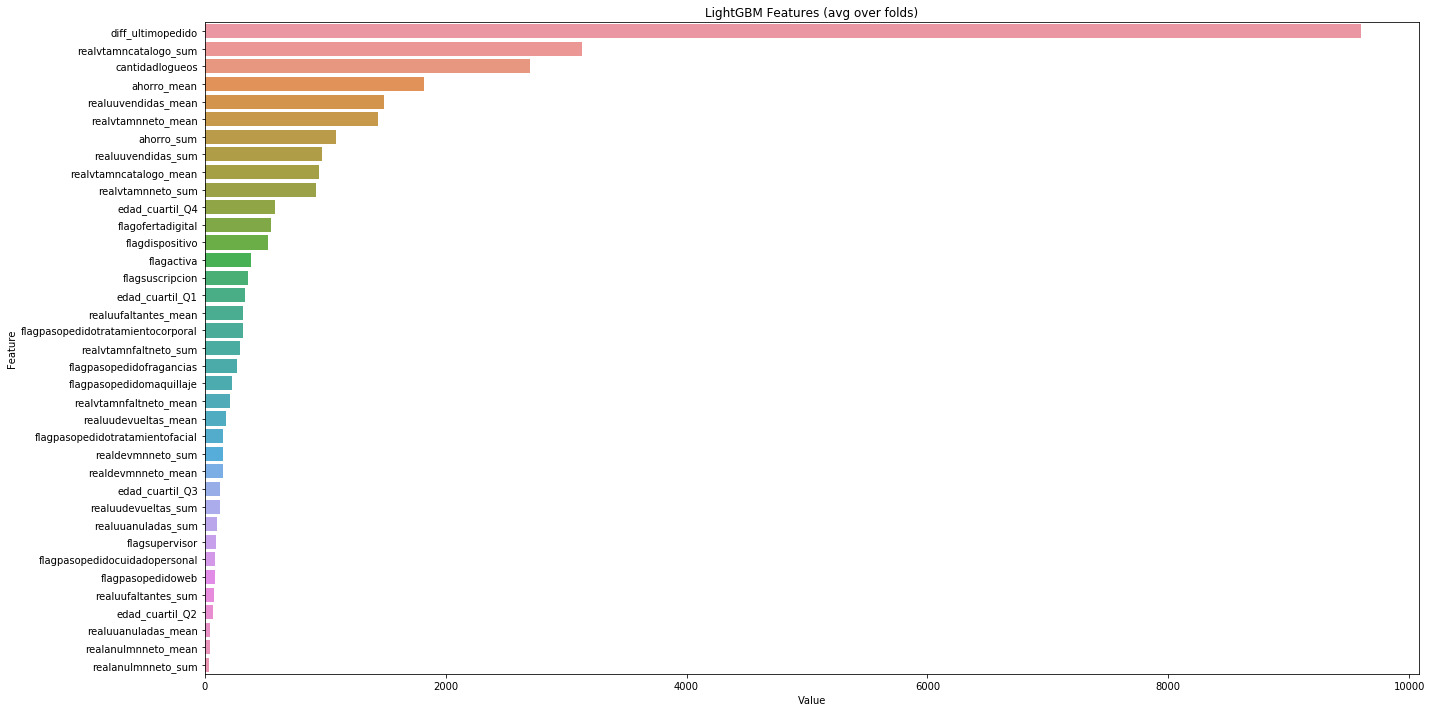

In [771]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_class.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

### Crossvalidation

# Submition

In [675]:
df_val.columns

Index(['Flagpasopedido', 'flagactiva', 'flagpasopedidocuidadopersonal',
       'flagpasopedidomaquillaje', 'flagpasopedidotratamientocorporal',
       'flagpasopedidotratamientofacial', 'flagpedidoanulado',
       'flagpasopedidofragancias', 'flagpasopedidoweb', 'cantidadlogueos',
       'flagdispositivo', 'flagdigital', 'flagofertadigital',
       'flagsuscripcion', 'edad_cuartil_Q1', 'edad_cuartil_Q2',
       'edad_cuartil_Q3', 'edad_cuartil_Q4', 'diff_ultimopedido', 'ahorro_sum',
       'realvtamncatalogo_sum', 'realvtamnneto_sum', 'realanulmnneto_sum',
       'realdevmnneto_sum', 'realuuanuladas_sum', 'realuudevueltas_sum',
       'realuufaltantes_sum', 'realuuvendidas_sum', 'realvtamnfaltneto_sum',
       'ahorro_mean', 'realvtamncatalogo_mean', 'realvtamnneto_mean',
       'realanulmnneto_mean', 'realdevmnneto_mean', 'realuuanuladas_mean',
       'realuudevueltas_mean', 'realuufaltantes_mean', 'realuuvendidas_mean',
       'realvtamnfaltneto_mean', 'Flag_shift'],
      dtype='obj

In [672]:
df_val.drop('campanaultimopedido', axis=1, inplace=True)

KeyError: "['campanaultimopedido'] not found in axis"

In [666]:
predict_bel.head()

,idconsultora,flagpasopedido
0,175391,NaN
1,336826,NaN
2,667498,NaN
3,386050,NaN
4,504579,NaN


In [685]:
df_sub_tmp = df_val.loc[predict_bel['idconsultora'].tolist()].drop('Flag_shift', axis=1)

## Sub 1

In [533]:
df_sub_tmp['Flag_shift'] = lgbm_class.predict_proba(df_sub_tmp)[:, 1]
df_sub_tmp.head()

,,Flagpasopedido,flagactiva,flagpasopedidocuidadopersonal,flagpasopedidomaquillaje,flagpasopedidotratamientocorporal,flagpasopedidotratamientofacial,flagpedidoanulado,flagpasopedidofragancias,flagpasopedidoweb,cantidadlogueos,...,realvtamncatalogo_mean,realvtamnneto_mean,realanulmnneto_mean,realdevmnneto_mean,realuuanuladas_mean,realuudevueltas_mean,realuufaltantes_mean,realuuvendidas_mean,realvtamnfaltneto_mean,Flag_shift
IdConsultora,campana,,,,,,,,,,,,,,,,,,,,,
202,201906,1,1,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,...,6965.000000,4977.375000,0.0,0.000000,0.0,0.000000,0.000000,1.750000,0.000000,0.789074
243,201906,1,1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,5.0,...,4770.288462,3162.134615,0.0,0.000000,0.0,0.000000,0.000000,1.269231,0.000000,0.985664
274,201906,1,1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,4.0,...,6362.318841,3715.811594,0.0,0.000000,0.0,0.000000,0.000000,1.275362,0.000000,0.983723
293,201906,1,1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,11.0,...,8295.327273,5768.236364,0.0,335.054545,0.0,0.154545,0.000000,2.200000,0.000000,0.980328
431,201906,1,1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,...,4908.333333,3572.666667,0.0,0.000000,0.0,0.000000,0.083333,1.166667,209.583333,0.963682


In [534]:
df_sub = df_sub_tmp.reset_index()[['IdConsultora', 'Flag_shift']]
df_sub = df_sub.set_index('IdConsultora').loc[predict_bel['idconsultora'].tolist()].reset_index()
df_sub.rename(columns={'IdConsultora': 'idconsultora', 'Flag_shift': 'flagpasopedido'}, inplace=True)
df_sub.head()

,idconsultora,flagpasopedido
0,175391,0.970491
1,336826,0.963737
2,667498,0.000030
3,386050,0.924478
4,504579,0.963879


In [535]:
df_sub.shape, predict_bel.shape

((120895, 2), (120895, 2))

In [536]:
df_sub.to_csv('watermelon3.csv', encoding='utf-8', index=None)